In [1]:
# load modules
import json
import os
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict, Counter, OrderedDict
import bhtsne
import scanpy
import scipy
import phenograph # install from https://github.com/jacoblevine/PhenoGraph
from pandas.core.index import RangeIndex
from scipy.io import mmread,mminfo
import gzip

# Plotting imports
import matplotlib
from matplotlib import cm 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import ListedColormap
from random import shuffle
import matplotlib.patches as mpatches

#sklearn
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
#Stats imports
import scipy.stats as stats
import random
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Load Data Objects

In [2]:
path=f"{os.getcwd()}/filtered_gene_bc_matrices/GRCh38"
gene_path = f"{path}/genes.tsv"
barcode_path = f"{path}/barcodes.tsv"
matrix_path = f"{path}/matrix.mtx"

In [3]:
gene_df=pd.read_csv(gene_path,sep='\t', names=['geneid','gene_name'])
barcode_df = pd.read_csv(barcode_path,sep='\t',names=['barcode'])

In [4]:
sparse_matrix = mmread(matrix_path)
desnse_matrix = sparse_matrix.todense()
dense_matrix_T = desnse_matrix.T
df = pd.DataFrame(dense_matrix_T)

# Q1

## Q1a. 
Filter the data if needed, and normalize the data by scaling to median library size. Project the log transformed normalized data to 2D using t-SNE or UMAP. Plot the 2D or 3D embedding [15pts].

## Filtering

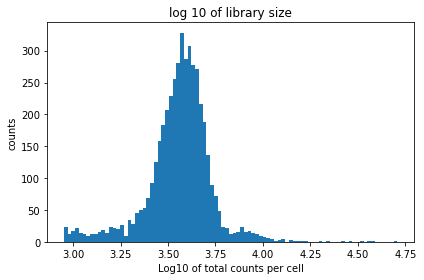

In [5]:
counts_log10 = np.log10(df.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

In [6]:
#filtering 
threshold = 3.3
ms = df.sum(axis=1)
use_cells = ms.index[np.log10(ms) > threshold]
reduced_df = df.loc[use_cells]

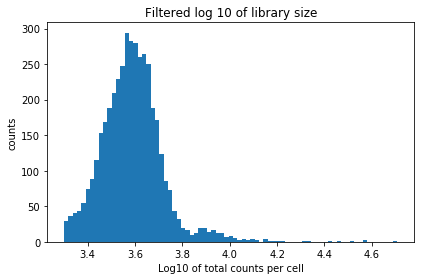

In [7]:
counts_log10 = np.log10(reduced_df.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('Filtered log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

In [8]:
#filtering 
threshold=3.85
ms = reduced_df.sum(axis=1)
use_cells = ms.index[np.log10(ms) < threshold]
reduced_df = reduced_df.loc[use_cells]

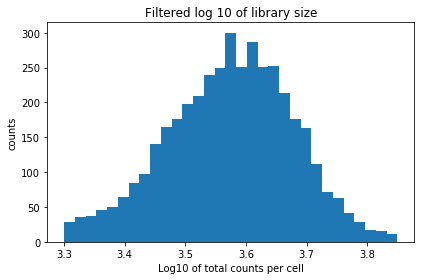

In [9]:
counts_log10 = np.log10(reduced_df.sum(axis=1))
plt.hist(counts_log10,bins='auto')
plt.title('Filtered log 10 of library size')
plt.xlabel('Log10 of total counts per cell')
plt.ylabel('counts')
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


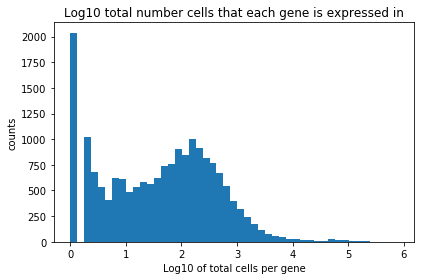

In [10]:
# Distrbution 
counts_log10 = np.log10(reduced_df.sum(axis=0))
plt.hist(counts_log10,bins='auto', range=(0,counts_log10.max()))
plt.title('Log10 total number cells that each gene is expressed in')
plt.xlabel('Log10 of total cells per gene')
plt.ylabel('counts')
plt.tight_layout()

In [11]:
ms=reduced_df.sum(axis=0)
use_genes = ms.index[np.log10(ms) > .5]
reduced_df = reduced_df[use_genes]

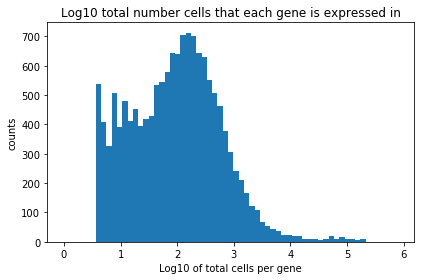

In [12]:
# Distrbution 
counts_log10 = np.log10(reduced_df.sum(axis=0))
plt.hist(counts_log10,bins='auto', range=(0,counts_log10.max()))
plt.title('Log10 total number cells that each gene is expressed in')
plt.xlabel('Log10 of total cells per gene')
plt.ylabel('counts')
plt.tight_layout()

In [13]:
print(f"{df.shape[0]-reduced_df.shape[0]} cells removed")
print(f"{df.shape[1]-reduced_df.shape[1]} genes removed")

462 cells removed
19142 genes removed


## Normalizing

In [14]:
#normalizing the data & taking log10 
ms = reduced_df.sum(axis=1) #library size
norm_df = reduced_df.div(ms, axis=0).mul(np.median(ms), axis=0) #normalize by lib size
log_df = np.log(0.1+ norm_df) #log of normalized df

## Visualization

In [15]:
from sklearn.decomposition import PCA
no_eigs = 100
pca_1 = PCA(n_components=no_eigs)
pca_1.fit(log_df.values)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

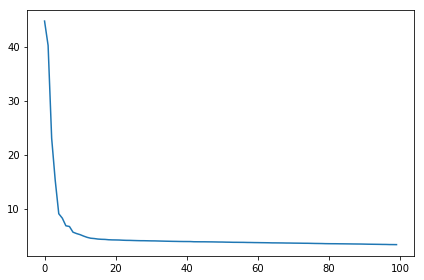

In [16]:
# Get Eiganvectors
eig_vectors = pca_1.components_
# Get Eiganvalues
eig_values = pca_1.explained_variance_
plt.plot(eig_values)
plt.tight_layout()

In [17]:
pca= PCA(n_components=25) #elbow of the graph
pca_results = pd.DataFrame(pca.fit_transform(log_df),
                index=log_df.index)

In [18]:
import umap

def perform_umap(pca_dataframe,neighbors=15): #15-50 neighbors
    reducer = umap.UMAP(n_neighbors=neighbors)
    embedding = reducer.fit_transform(pca_dataframe)
    return embedding

def graph_umap(raw_df,norm_df,umap_output,title):
    ms=raw_df.sum(axis=1)
    plt.figure(figsize=[5, 3.5])
    plt.scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    plt.title(f'{title} UMAP colored by log 10 of expression')
    plt.colorbar()
    
def perform_tsne(num_PC,pca_projections, perplexity, log_df):
    use_eigs = list(range(1, num_PC))
    data = pca_projections.values[:, use_eigs] 
    # tsNE
    tsne = pd.DataFrame(bhtsne.tsne(data, perplexity=perplexity), 
                index=log_df.index, columns=['x', 'y'])
    return tsne

def graph_tsne(raw_df,norm_df,tsne,title):
    ms = raw_df.sum(axis=1)
    plt.figure(figsize=[5, 3.5])
    plt.scatter(tsne['x'], tsne['y'], s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    plt.title(f'{title} tSNE colored by log 10 of expression')
    plt.colorbar()

def side_by_side(tsne,umap,raw_df,norm_df,title):
    ms=raw_df.sum(axis=1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    #umap
    plot1=ax[0].scatter(umap[:, 0],umap[:, 1],s=5, edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    ax[0].set_title(f"UMAP of {title}")
    fig.colorbar(plot1,ax=ax[0])
    #tsne
    plot2=ax[1].scatter(tsne['x'], tsne['y'], s=5, edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    ax[1].set_title(f"tSNE of {title}")
    fig.colorbar(plot2,ax=ax[1])

In [19]:
#visualizaton based on log dataframe
umap_output = perform_umap(log_df)

tsne_output = pd.DataFrame(bhtsne.tsne(log_df, perplexity=30), 
                index=log_df.index, columns=['x', 'y'])

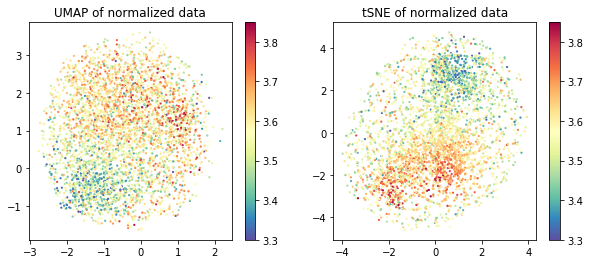

In [20]:
side_by_side(tsne_output,umap_output,reduced_df, norm_df, 'normalized data')

In [21]:
umap_output = perform_umap(pca_results,neighbors=10)
tsne_output = perform_tsne(25,pca_results,30,log_df)

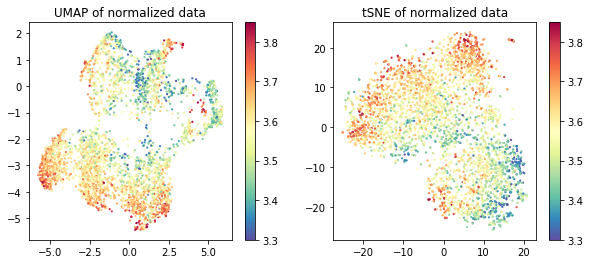

In [22]:
side_by_side(tsne_output,umap_output,reduced_df, norm_df, 'normalized data')

# Q1B

the embedding suggests continuous trajectories charicterizing the heterogenaity in the T cells, rather than distinct groups. 

# Q2A
Compute a Diffusion map representation of the log normalized data using scanpy.tl.diffmap or any other implementation of your choice. What is the size of each diffusion component (eigenvector)? [15pt]

--> each diffusion component is of length 4076, which is the number of cells.

In [23]:
import anndata
ad = anndata.AnnData(X=log_df, obs = barcode_df.loc[log_df.index], var = gene_df.loc[log_df.columns])

Transforming to str index.
Transforming to str index.


In [24]:
ad

AnnData object with n_obs × n_vars = 4076 × 14552 
    obs: 'barcode'
    var: 'geneid', 'gene_name'

In [25]:
scanpy.pp.neighbors(ad,n_pcs=25,method='umap')

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [26]:
scanpy.tl.diffmap(ad)

In [27]:
diffusion_components = ad.obsm['X_diffmap']

In [28]:
print("diffusion component shape: ",diffusion_components.shape)
print("size of single diffustion component (eigenvector): ",diffusion_components.T[0].shape)

diffusion component shape:  (4076, 15)
size of single diffustion component (eigenvector):  (4076,)


# Q2b.
Color the embedding in Q1a with the first 3 diffusion components found in Q2a[15 pts].

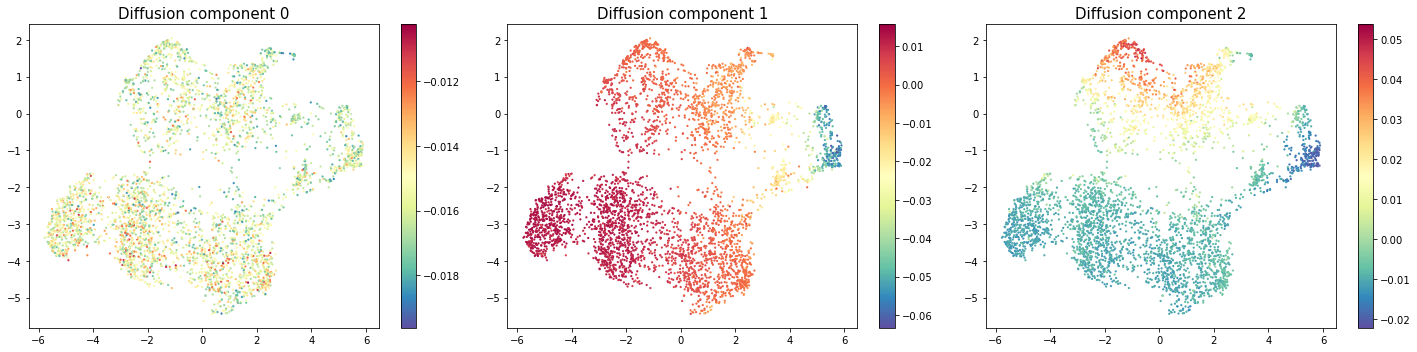

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
#Diff component 1
plot1=ax[0].scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=diffusion_components.T[0])
ax[0].set_title("Diffusion component 0",fontsize=15)
fig.colorbar(plot1,ax=ax[0])
#diff component 2
plot2=ax[1].scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=diffusion_components.T[1])
ax[1].set_title("Diffusion component 1",fontsize=15)
fig.colorbar(plot2,ax=ax[1])
#diff component 3
plot2=ax[2].scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=diffusion_components.T[2])
ax[2].set_title("Diffusion component 2",fontsize=15)
fig.colorbar(plot2,ax=ax[2])
fig.tight_layout()

# Q2c. 

Project the T cells in the space of the first two diffusion components. How does the structure compare to the visualization of the same cells with tSNE or Umap? [10 pt]

This structure is much more linear in shape, and shoows much more promise of 2 distinct groups than the UMAP or tSNE did. 


... storing 'gene_name' as categorical


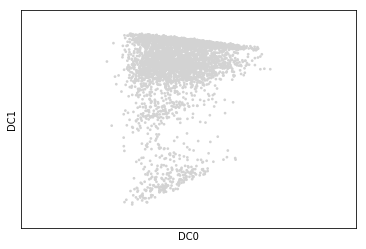

In [30]:
#scanpy.pl.diffmap(ad,gene_symbols='gene_name',components=[0,1],color='neighbors')
scanpy.pl.diffmap(ad,gene_symbols='gene_name',components=[0,1])

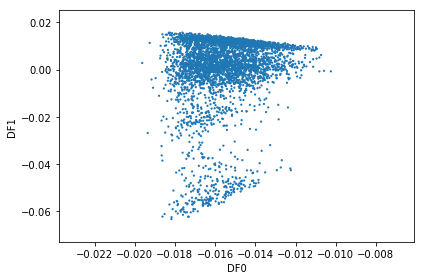

In [31]:
plt.scatter(diffusion_components[:,0],diffusion_components[:,1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r) #,c=np.log10(ms[norm_df.index]))
plt.xlabel('DF0')
plt.ylabel('DF1')
plt.tight_layout()

# Q2d. 

Compute the Pearson correlation between expression of each gene and the second diffusion component. List the top 10 genes with highest correlation with the diffusion component [10pts].

In [32]:
h = []
for gene in reduced_df.columns:
    name = gene_df['gene_name'][gene]
    r,p =scipy.stats.pearsonr(diffusion_components[:,1],norm_df.loc[:,gene]) #second diffusion component
    if p <=0.05: #must be statistically signifigant 
        h.append((r,gene,name))

In [33]:
import heapq
n_largest = heapq.nlargest(10,h)

In [34]:
n_largest

[(0.5539471916960732, 5538, 'RPL32'),
 (0.5392819643092912, 7966, 'RPL34'),
 (0.5377770325324194, 15890, 'RPS6'),
 (0.537202622149723, 26699, 'RPL13'),
 (0.527508887422758, 8234, 'RPS3A'),
 (0.5270982760737195, 17381, 'RPS13'),
 (0.4936056664714212, 484, 'RPL11'),
 (0.46458884176014725, 7477, 'RPL9'),
 (0.46346596896240316, 22065, 'RPL21'),
 (0.4632865509378026, 9146, 'RPS23')]

In [35]:
n_largest_gene_cols = [x[1] for x in n_largest]
n_largest_gene_names = [x[2] for x in n_largest]

In [46]:
print('10 genes with highest correlation:')
print(n_largest_gene_names)

10 genes with highest correlation:
['RPL32', 'RPL34', 'RPS6', 'RPL13', 'RPS3A', 'RPS13', 'RPL11', 'RPL9', 'RPL21', 'RPS23']


# Q2e. 
Plot a heatmap of genes by cells displaying expression of the 10 genes found in Q1d with cells ordered by the first diffusion component [10pts].

In [36]:
heatmap_df = norm_df.loc[:,n_largest_gene_cols]

In [42]:
heatmap_df.loc[cells_ordered_by_diff1.index]

5538       7966       15890      26699      8234       17381  \
4373  30.402189  26.208784  12.580216  19.918676  15.725270   7.338459   
423   17.294837  32.554988  21.364211  17.294837  13.225464   9.156090   
3014  13.178335  22.403170  11.860502  26.356670  11.860502   7.907001   
55     7.753074  21.320953  18.413550  18.413550  11.629611   5.814805   
1861  17.225691  22.147317  11.073659  14.764878  15.995285   6.152033   
...         ...        ...        ...        ...        ...        ...   
2413  38.329018  48.550090  42.587798  34.070239  34.070239  14.479851   
4240  31.811939  57.261491  42.415919  41.355521  28.630746  18.026766   
1595  51.689680  64.612101  37.844230  39.690290  33.229080  13.845450   
3343  37.973929  59.276377  46.309670  43.531089  34.269155  19.450061   
1662  48.013959  61.981657  42.776073  47.140978  28.808376  22.697508   

          484        7477       22065      9146   
4373  12.580216   4.193405  22.015378  18.870324  
423   22.381554  13.225464  31.537645  15.260151  
3014  17.131836   6.589168  23.721003   7.907001  
55    16.475282  11.629611  24.228356  11.629611  
1861   8.612846   6.152033  46.755447   3.691220  
...         ...        ...        ...        ...  
2413  18.738631  29.811459  63.029941  23.849167  
4240  22.268358  19.087164  47.717909  24.389154  
1595  23.998780  15.691510  63.689071  20.306660  
3343  26.859608  22.228641  54.645410  25.933415  
1662  25.316451  20.951546  58.489732  22.697508  

[4076 rows x 10 columns]

In [38]:
diff1 = pd.Series(diffusion_components[:,1],index=log_df.index)

In [41]:
cells_ordered_by_diff1=diff1.sort_values()

In [43]:
cells_ordered_by_diff1.index

Int64Index([4373,  423, 3014,   55, 1861,  470, 2619, 4309, 2368, 2291,
            ...
            2752, 1344, 2807, 2769, 2217, 2413, 4240, 1595, 3343, 1662],
           dtype='int64', length=4076)

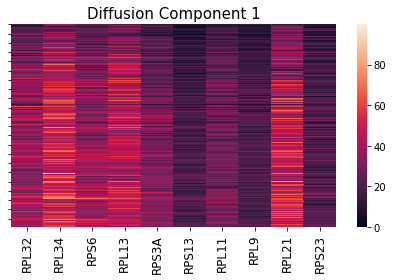

In [44]:
ax=sns.heatmap(heatmap_df.loc[cells_ordered_by_diff1.index],cbar=True)
ax.set_xticklabels(n_largest_gene_names,fontsize=12)
ax.set_yticklabels([])
plt.title('Diffusion Component 1',fontsize=15)
plt.tight_layout()

# Q2F
Repeat Q2d,e for the third diffusion component [20pts].

In [47]:
h = []
for gene in reduced_df.columns:
    name = gene_df['gene_name'][gene]
    r,p =scipy.stats.pearsonr(diffusion_components[:,2],norm_df.loc[:,gene])
    if p <=0.05: #must be statistically signifigant 
        h.append((r,gene,name))

In [48]:
n_largest = heapq.nlargest(10,h)

In [49]:
n_largest_gene_cols = [x[1] for x in n_largest]
n_largest_gene_names = [x[2] for x in n_largest]
n_largest

[(0.368799573546034, 18028, 'MALAT1'),
 (0.31125766597942783, 13252, 'GIMAP7'),
 (0.29864228968252665, 33662, 'MT-ND5'),
 (0.2831985395614356, 1695, 'TXNIP'),
 (0.2418665307894327, 1674, 'CH17-373J23.1'),
 (0.21588816330691085, 13253, 'GIMAP4'),
 (0.2102525263969152, 30158, 'STMN3'),
 (0.21016972340206871, 27224, 'RP11-160E2.6'),
 (0.2093279593366536, 23126, 'RPS29'),
 (0.20719177103199668, 2694, 'TRAF3IP3')]

In [50]:
print('10 most correlated genes: ')
print(n_largest_gene_names)

10 most correlated genes: 
['MALAT1', 'GIMAP7', 'MT-ND5', 'TXNIP', 'CH17-373J23.1', 'GIMAP4', 'STMN3', 'RP11-160E2.6', 'RPS29', 'TRAF3IP3']


In [51]:
heatmap_df = norm_df.loc[:,n_largest_gene_cols]
diff2 = pd.Series(diffusion_components[:,2],index=log_df.index)
cells_ordered_by_diff2=diff2.sort_values()

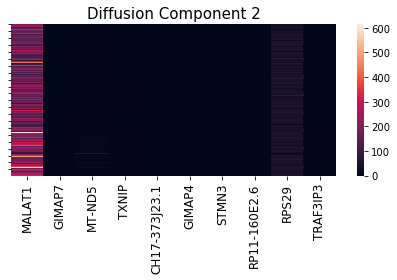

In [52]:
ax=sns.heatmap(heatmap_df.loc[cells_ordered_by_diff2.index],cbar=True)
ax.set_xticklabels(n_largest_gene_names,fontsize=12)
ax.set_yticklabels([])
plt.title('Diffusion Component 2',fontsize=15)
plt.tight_layout()

# Q2g
Repeat parts d,e,f above for genes with the most negative correlation with the diffusion components [bonus 5pts]. How would you characterize the  two components [bonus 10pts]?

## Diffusion Component 0

In [53]:
h = []
for gene in reduced_df.columns:
    name = gene_df['gene_name'][gene]
    r,p =scipy.stats.pearsonr(diffusion_components[:,1],norm_df.loc[:,gene])
    if p <=0.05: #must be statistically signifigant 
        h.append((r,gene,name))

In [54]:
n_smallest=heapq.nsmallest(10,h)

In [55]:
n_smallest

[(-0.834948754546727, 31866, 'NKG7'),
 (-0.7643752964818689, 27520, 'CCL5'),
 (-0.7336371432950819, 22972, 'GZMH'),
 (-0.6975613501663802, 29601, 'CST7'),
 (-0.6803588060609805, 10619, 'HLA-B'),
 (-0.6789867995582253, 3977, 'GNLY'),
 (-0.6707274584632217, 24383, 'B2M'),
 (-0.6439568365311085, 8900, 'GZMA'),
 (-0.6298982360147055, 7360, 'FGFBP2'),
 (-0.6165386840155679, 10617, 'HLA-C')]

In [56]:
n_smallest_gene_cols = [x[1] for x in n_smallest]
n_smallest_gene_names = [x[2] for x in n_smallest]

In [57]:
heatmap_df = norm_df.loc[:,n_smallest_gene_cols]
diff1 = pd.Series(diffusion_components[:,1],index=log_df.index)
cells_ordered_by_diff1=diff1.sort_values()

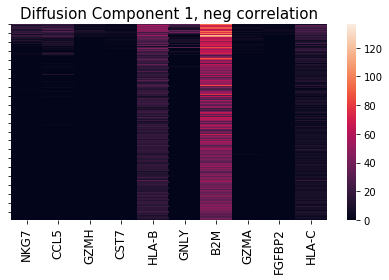

In [58]:
ax=sns.heatmap(heatmap_df.loc[cells_ordered_by_diff1.index],cbar=True)
ax.set_xticklabels(n_smallest_gene_names,fontsize=12)
ax.set_yticklabels([])
plt.title('Diffusion Component 1, neg correlation',fontsize=15)
plt.tight_layout()

## Diffusion component 2

In [59]:
h = []
for gene in reduced_df.columns:
    name = gene_df['gene_name'][gene]
    r,p =scipy.stats.pearsonr(diffusion_components[:,2],norm_df.loc[:,gene])
    if p <=0.05: #must be statistically signifigant 
        h.append((r,gene,name))

In [60]:
n_smallest=heapq.nsmallest(10,h)
n_smallest_gene_cols = [x[1] for x in n_smallest]
n_smallest_gene_names = [x[2] for x in n_smallest]
n_smallest

[(-0.5569779097537387, 27725, 'EIF1'),
 (-0.5228561280864039, 3486, 'YPEL5'),
 (-0.45062520519420407, 17874, 'FTH1'),
 (-0.43266757960677804, 19471, 'SRGN'),
 (-0.4189672664924064, 11197, 'PNRC1'),
 (-0.40867111120156857, 22187, 'RGCC'),
 (-0.3941839841318793, 4517, 'CXCR4'),
 (-0.391674608825174, 4602, 'NR4A2'),
 (-0.3907003269599899, 30712, 'JUNB'),
 (-0.38551431986693724, 23044, 'NFKBIA')]

In [61]:
heatmap_df = norm_df.loc[:,n_smallest_gene_cols]
diff2 = pd.Series(diffusion_components[:,2],index=log_df.index)
cells_ordered_by_diff2=diff2.sort_values()

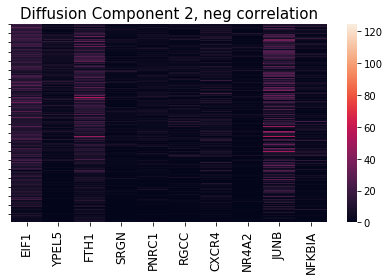

In [62]:
ax=sns.heatmap(heatmap_df.loc[cells_ordered_by_diff2.index],cbar=True)
ax.set_xticklabels(n_smallest_gene_names,fontsize=12)
ax.set_yticklabels([])
plt.title('Diffusion Component 2, neg correlation',fontsize=15)
plt.tight_layout()

I would charicterize the first two components as immune cells associated with leukocytes 